In [85]:
%pip install -r requirements.txt

In [3]:
%matplotlib inline
import tensorflow as tf
import keras as k
from keras import layers

from keras_preprocessing.image import ImageDataGenerator
from keras.models import clone_model
from keras.applications import ResNet50

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2
import os
import shutil

from PIL import Image

2024-01-27 21:25:33.566340: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-27 21:25:33.566480: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-27 21:25:33.633967: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-27 21:25:33.773197: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-27 21:25:34.954999: W tensorflow/compiler/tf2

In [4]:
def conv_block(inputs, filters_n):
    n = layers.Conv2D(filters_n, 3, padding="same")(inputs)
    n = layers.BatchNormalization()(n)
    n = layers.Activation("relu")(n)
    
    n = layers.Conv2D(filters_n, 3, padding="same")(n)
    n = layers.BatchNormalization()(n)
    n = layers.Activation("relu")(n)
    
    return n

def encoder_block(inputs, filters_n):
    x = conv_block(inputs, filters_n)
    p = layers.MaxPool2D(pool_size=(2,2))(x)
    return x, p

def decoder_block(inputs, skip, filters_n):
    x = layers.Conv2DTranspose(filters_n, kernel_size=(2,2), strides=2, padding="same")(inputs)
    x = layers.Concatenate()([x, skip])
    x = conv_block(x, filters_n)
    return x


def U_Net(input_shape):
    inputs = layers.Input(shape=input_shape)
    inputs2 = layers.Rescaling(1. /255)(inputs)
    resnet50 = k.applications.ResNet50(include_top=False, weights="imagenet", input_tensor=inputs2)

    #encode
    s1 = resnet50.get_layer("input_1").output  #512x512
    s2 = resnet50.get_layer("conv1_relu").output  #256x256
    s3 = resnet50.get_layer("conv2_block3_out").output  #128x128
    s4 = resnet50.get_layer("conv3_block4_out").output  #64x64

    #bottleneck
    bottleneck = resnet50.get_layer("conv4_block6_out").output  #32x32

    #decode
    decode1 = decoder_block(bottleneck, s4, 512)
    decode2 = decoder_block(decode1, s3, 256)
    decode3 = decoder_block(decode2, s2, 128)
    decode4 = decoder_block(decode3, s1, 64)
    
    #condense 
    outputs = layers.Conv2D(1,1, padding="same", activation="sigmoid")(decode4)
    model = k.Model(inputs=inputs, outputs=outputs, name="unet")
    return model

model = U_Net((256,256,3))
model.summary()
model.save("seg_model.keras")

2024-01-27 17:09:37.581536: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-27 17:09:37.783722: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-27 17:09:37.783773: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-27 17:09:37.785916: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-27 17:09:37.785961: I external/local_xla/xla/stream_executor

Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 256, 256, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['rescaling[0][0]']           
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                               

In [4]:
#classification

def classi(input_shape):
    inputs = layers.Input(shape=input_shape)
    vgg19 = k.applications.VGG19(include_top=False, weights="imagenet", input_tensor=inputs)
    x = vgg19(inputs, training=False)
    
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.BatchNormalization()(x)
    #classi layers
    for filters in [96, 128, 256]:#, 320]:#, 512]:#, 1024, 2048]:
        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.Activation("relu")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.Activation("relu")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    #output
    x = layers.Dropout(rate=0.3)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="sigmoid")(x)

    output = layers.Dense(7, activation="softmax")(x)

    model = k.Model(inputs=inputs, outputs=output, name="classification")
    return model

classification = classi((256,256,3))
classification.summary()

classification.save("classification.keras")

2024-01-27 21:25:41.899386: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-27 21:25:42.108704: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-27 21:25:42.108835: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-27 21:25:42.111997: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-27 21:25:42.112068: I external/local_xla/xla/stream_executor

Model: "classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 64)          294976    
                                                                 
 activation (Activation)     (None, 8, 8, 64)          0         
                                                                 
 batch_normalization (Batch  (None, 8, 8, 64)          256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 96)          55392     
                                                    

In [6]:
def load_folder_imgs(folder, numimgs, startind, img_shape):
    images = []
    folderfiles = os.listdir(folder)
    for i in range(numimgs):
        if len(folderfiles) > i+startind+1: 
            img = cv2.imread(os.path.join(folder,folderfiles[i+startind]))
            if img is not None:
                images.append(np.array(cv2.resize(img, dsize=img_shape)))
    return [images, i+startind]

datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=0.1,
                             horizontal_flip=True,
                             vertical_flip=True,
                             )

In [5]:
# For loading classification labels and images.
# Standard Function, random sampling
def load_images_and_labels(images_path, labels_path, batch_size, image_shape, verbose=False):
    ds_images = []
    ds_labels = []
    data_indexes = []
    labels = pd.read_csv(labels_path)
    images = os.listdir(images_path)
    if verbose:
        print(f"loading images from {images_path} and labels from {labels_path}")
    for i in range(batch_size):
        random_index = np.random.randint(0, len(images)-2)
        if random_index >= len(images):
            random_index -=1
        img = cv2.imread(os.path.join(images_path, images[random_index]))
        row = labels.iloc[random_index, 1:]

        if img is not None and row is not None:
            if random_index not in data_indexes:
                data_indexes.append(random_index)
                ds_images.append(np.array(cv2.resize(img, dsize=image_shape)))
                ds_labels.append(row.values)
    return np.array(ds_images).astype(np.int16), np.array(ds_labels).astype(np.int16)

# Equal Sampling
def load_images_and_labels_equal(images_path, labels_path, batch_size, num_classes, image_shape, verbose=False):
    ds_images = []
    ds_labels = []
    data_indexes = []
    labels = pd.read_csv(labels_path)
    images = os.listdir(images_path)
    samples_per_class = [batch_size//num_classes for i in np.zeros(num_classes)]
    samples_per_class = [x+1 for x in range(batch_size%num_classes)]
    instances_per_class = labels.sum()

    if verbose:
        print(f"loading images from {images_path} and labels from {labels_path} with equal sampling")
    for i in range(num_classes):
        class_indexes = [i for i, n in enumerate(labels.iloc[:,i]) if n == 1]
        for x in range(samples_per_class[i]):
            random_index = np.random.randint(0, instances_per_class[i]-2)
            if random_index >= instances_per_class[i]-1:
                random_index -=1
            ind = class_indexes[random_index]
            img = cv2.imread(os.path.join(images_path, images[ind]))
            row = labels.iloc[ind, 1:]
            if img is not None and row is not None:
                if random_index not in data_indexes:
                    data_indexes.append(random_index)
                    ds_images.append(np.array(cv2.resize(img, dsize=image_shape)))
                    ds_labels.append(row.values)
    return np.array(ds_images).astype(np.int16), np.array(ds_labels).astype(np.int16)

#Oversampling Minority
def load_images_and_labels(images_path, labels_path, batch_size, image_shape, verbose=False):
    ds_images = []
    ds_labels = []
    data_indexes = []
    labels = pd.read_csv(labels_path)
    images = os.listdir(images_path)
    if verbose:
        print(f"loading images from {images_path} and labels from {labels_path}")
    for i in range(batch_size):
        random_index = np.random.randint(0, len(images)-2)
        if random_index >= len(images):
            random_index -=1
        img = cv2.imread(os.path.join(images_path, images[random_index]))
        row = labels.iloc[random_index, 1:]

        if img is not None and row is not None:
            if random_index not in data_indexes:
                data_indexes.append(random_index)
                ds_images.append(np.array(cv2.resize(img, dsize=image_shape)))
                ds_labels.append(row.values)
    return np.array(ds_images).astype(np.int16), np.array(ds_labels).astype(np.int16)


In [11]:
cls_train_gt = 'train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv'#("classi/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv")
cls_val = r'validation/ISIC2018_Task3_Validation_Input/'
cls_val_gt = "validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv"

#weighted binary loss
def get_weights(labels):
    cols = len(labels.columns)-2 #assumes 1 column for image ids
    weights = {}
    for i in range(cols+1):
        weights[i] = 1-np.mean(labels[labels.columns[i+1]].tolist())
    return weights

print(get_weights(pd.read_csv(cls_train_gt)))

from keras import backend as K
def f_score(y_true, y_pred, threshold=0.1, beta=2):
    tp = tp_score(y_true, y_pred, threshold)
    fp = fp_score(y_true, y_pred, threshold)
    fn = fn_score(y_true, y_pred, threshold)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    return (1+beta**2) * ((precision * recall) / ((beta**2)*precision + recall))

def tp_score(y_true, y_pred, threshold=0.1):
    tp_3d = K.concatenate(
        [
            K.cast(K.expand_dims(K.flatten(y_true)), 'bool'),
            K.cast(K.expand_dims(K.flatten(K.greater(y_pred, K.constant(threshold)))), 'bool'),
            K.cast(K.ones_like(K.expand_dims(K.flatten(y_pred))), 'bool')
        ], axis=1
    )
    tp = K.sum(K.cast(K.all(tp_3d, axis=1), 'int32'))
    return tp

def fp_score(y_true, y_pred, threshold=0.1):
    fp_3d = K.concatenate(
        [
            K.cast(K.expand_dims(K.flatten(K.abs(y_true - K.ones_like(y_true)))), 'bool'),
            K.cast(K.expand_dims(K.flatten(K.greater(y_pred, K.constant(threshold)))), 'bool'),
            K.cast(K.ones_like(K.expand_dims(K.flatten(y_pred))), 'bool')
        ], axis=-1
    )

    fp = K.sum(K.cast(K.all(fp_3d, axis=1), 'int32'))
    return fp

def fn_score(y_true, y_pred, threshold=0.1):
    fn_3d = K.concatenate(
        [
            K.cast(K.expand_dims(K.flatten(y_true)), 'bool'),
            K.cast(K.expand_dims(K.flatten(K.abs(K.cast(K.greater(y_pred, K.constant(threshold)), 'float') - K.ones_like(y_pred)))), 'bool'),
            K.cast(K.ones_like(K.expand_dims(K.flatten(y_pred))), 'bool')
        ], axis=1
    )

    fn = K.sum(K.cast(K.all(fn_3d, axis=1), 'int32'))
    return fn

def precision_score(y_true, y_pred, threshold=0.1):
    tp = tp_score(y_true, y_pred, threshold)
    fp = fp_score(y_true, y_pred, threshold)
    return tp / (tp + fp)

def recall_score(y_true, y_pred, threshold=0.1):
    tp = tp_score(y_true, y_pred, threshold)
    fn = fn_score(y_true, y_pred, threshold)
    return tp / (tp + fn)


{0: 0.888866699950075, 1: 0.3305042436345482, 2: 0.9486769845232151, 3: 0.9673489765351972, 4: 0.8902646030953569, 5: 0.9885172241637543, 6: 0.9858212680978532}


In [8]:
#classification = k.models.load_model('classification.keras') #reset weights
optimizer = tf.keras.optimizers.SGD(learning_rate=0.2)
classification.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["binary_accuracy", f_score, precision_score, 'AUC']) 

callback_list = [tf.keras.callbacks.EarlyStopping(patience=1.2)] #can adjust to improve accuracy
batch_size=8
spe = 10015//batch_size #steps per epoch
epochs = 60 # set to 1 for debugging purposes
seed = 123

cls_val = r'validation/ISIC2018_Task3_Validation_Input/'
cls_val_gt = "validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv"

cls_train = r'train/ISIC2018_Task3_Training_Input/'#r"classi/ISIC2018_Task3_Training_Input/ISIC2018_Task3_Training_Input/" 
cls_train_gt = 'train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv'#("classi/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv")

for i in range(epochs):
    train_ds, train_gt = load_images_and_labels_equal(cls_train, cls_train_gt, batch_size, 7, (256,256), True)
    val_ds, val_gt = load_images_and_labels_equal(cls_val, cls_val_gt, batch_size, 7, (256,256), True)

    print(f"train_ds len: {len(train_ds)}, train labels len: {len(train_gt)}")
    cls_train_gen = datagen.flow(x=train_ds, y=train_gt, seed=seed, batch_size=batch_size*spe)
    val_train_gen = datagen.flow(x=val_ds, y=val_gt, seed=seed, batch_size=batch_size*spe)
    history = classification.fit(cls_train_gen, steps_per_epoch=spe, 
                                 class_weight=get_weights(pd.read_csv(cls_train_gt)), 
                                 batch_size=batch_size, callbacks=callback_list, verbose=1,
                                 validation_data=(val_train_gen.x, val_train_gen.y), validation_steps=32)
    print(f"--------------- Done epoch {i} -----------------")

#classification.save("final_class.keras")



loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 8, train labels len: 8


2024-01-27 21:26:20.502151: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inclassification/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-01-27 21:26:20.897941: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-27 21:26:21.014685: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-27 21:26:21.167862: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-27 21:26:23.237531: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f4744173890 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-27 21:26:23.237573: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RT

   1/1251 [..............................] - ETA: 3:42:07 - loss: 1.5693 - binary_accuracy: 0.8571 - f_score: nan - precision_score: 0.0000e+00 - auc: 0.0846WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 1251 batches). You may need to use the repeat() function when building your dataset.


2024-01-27 21:26:29.198490: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5495791633570982489
2024-01-27 21:26:29.198544: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5838935769203786832
2024-01-27 21:26:29.198553: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17114671745680317710
2024-01-27 21:26:29.198558: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13393409689382143556
2024-01-27 21:26:29.198561: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14133020422727923616


1251/1251 [==============================] - 11s 567us/step - loss: 1.5693 - binary_accuracy: 0.8571 - f_score: nan - precision_score: 0.0000e+00 - auc: 0.0846 - val_loss: 3.6096 - val_binary_accuracy: 0.7143 - val_f_score: nan - val_precision_score: 0.0000e+00 - val_auc: 0.6042


2024-01-27 21:26:29.864171: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12267658331913051033
2024-01-27 21:26:29.864227: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2196055103827479659


--------------- Done epoch 0 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 8, train labels len: 8
   1/1251 [..............................] - ETA: 2:55 - loss: 0.6774 - binary_accuracy: 0.8929 - f_score: 0.7018 - precision_score: 0.3200 - auc: 0.8646WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 1251 batches). You may need to use the repeat() function when building your dataset.


2024-01-27 21:26:30.311038: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13393409689382143556


1251/1251 [==============================] - 1s 812us/step - loss: 0.6774 - binary_accuracy: 0.8929 - f_score: 0.7018 - precision_score: 0.3200 - auc: 0.8646 - val_loss: 1.4233 - val_binary_accuracy: 0.7959 - val_f_score: 0.6383 - val_precision_score: 0.3158 - val_auc: 0.7976
--------------- Done epoch 1 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 8, train labels len: 8
1251/1251 [==============================] - 0s 94us/step - loss: 0.3924 - binary_accuracy: 0.9286 - f_score: 0.8333 - precision_score: 0.5000 - auc: 0.9609 - val_loss: 1.3837 - val_binary_accuracy: 0.8367 - val_f_score: 0.6122 - val_precision_score: 0.2857 - val_auc: 0.8333
-----------

2024-01-27 21:26:31.734176: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13393409689382143556


train_ds len: 8, train labels len: 8
1251/1251 [==============================] - 0s 93us/step - loss: 0.4276 - binary_accuracy: 0.7857 - f_score: 0.8333 - precision_score: 0.5000 - auc: 0.8802 - val_loss: 2.1817 - val_binary_accuracy: 0.8367 - val_f_score: 0.4286 - val_precision_score: 0.4286 - val_auc: 0.8095
--------------- Done epoch 3 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv


2024-01-27 21:26:32.267033: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13393409689382143556


train_ds len: 8, train labels len: 8
1251/1251 [==============================] - 0s 90us/step - loss: 0.6207 - binary_accuracy: 0.9286 - f_score: 0.7500 - precision_score: 0.7500 - auc: 0.9648 - val_loss: 1.8121 - val_binary_accuracy: 0.8367 - val_f_score: 0.7143 - val_precision_score: 0.4286 - val_auc: 0.8214
--------------- Done epoch 4 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv


2024-01-27 21:26:32.769003: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13393409689382143556
2024-01-27 21:26:32.769060: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14133020422727923616


train_ds len: 8, train labels len: 8
1251/1251 [==============================] - 0s 97us/step - loss: 0.6487 - binary_accuracy: 0.7857 - f_score: 0.2500 - precision_score: 0.2500 - auc: 0.8997 - val_loss: 2.7632 - val_binary_accuracy: 0.8367 - val_f_score: 0.4286 - val_precision_score: 0.4286 - val_auc: 0.8146
--------------- Done epoch 5 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv


2024-01-27 21:26:33.310287: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13393409689382143556


train_ds len: 8, train labels len: 8
1251/1251 [==============================] - 0s 89us/step - loss: 0.7720 - binary_accuracy: 0.9286 - f_score: 0.7500 - precision_score: 0.7500 - auc: 0.9505 - val_loss: 1.4941 - val_binary_accuracy: 0.8367 - val_f_score: 0.7143 - val_precision_score: 0.4286 - val_auc: 0.7959
--------------- Done epoch 6 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 8, train labels len: 8


2024-01-27 21:26:33.807813: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13393409689382143556


1251/1251 [==============================] - 0s 90us/step - loss: 0.4945 - binary_accuracy: 0.7857 - f_score: 0.8333 - precision_score: 0.5000 - auc: 0.8971 - val_loss: 1.9130 - val_binary_accuracy: 0.8367 - val_f_score: 0.4286 - val_precision_score: 0.4286 - val_auc: 0.8231
--------------- Done epoch 7 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv


2024-01-27 21:26:34.295723: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13393409689382143556


train_ds len: 8, train labels len: 8
1251/1251 [==============================] - 0s 92us/step - loss: 0.5780 - binary_accuracy: 0.9286 - f_score: 0.7500 - precision_score: 0.7500 - auc: 0.9740 - val_loss: 1.5430 - val_binary_accuracy: 0.8367 - val_f_score: 0.7143 - val_precision_score: 0.4286 - val_auc: 0.8112
--------------- Done epoch 8 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv


2024-01-27 21:26:34.788327: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5495791633570982489
2024-01-27 21:26:34.788358: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5838935769203786832
2024-01-27 21:26:34.788362: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17114671745680317710
2024-01-27 21:26:34.788366: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13393409689382143556
2024-01-27 21:26:34.788370: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14133020422727923616


train_ds len: 8, train labels len: 8
1251/1251 [==============================] - 0s 91us/step - loss: 0.5016 - binary_accuracy: 0.7857 - f_score: 0.8333 - precision_score: 0.5000 - auc: 0.8802 - val_loss: 2.0920 - val_binary_accuracy: 0.8367 - val_f_score: 0.4286 - val_precision_score: 0.4286 - val_auc: 0.7840
--------------- Done epoch 9 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv


2024-01-27 21:26:35.296347: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5495791633570982489
2024-01-27 21:26:35.296385: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5838935769203786832
2024-01-27 21:26:35.296392: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17114671745680317710
2024-01-27 21:26:35.296396: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13393409689382143556
2024-01-27 21:26:35.296400: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14133020422727923616


train_ds len: 8, train labels len: 8
1251/1251 [==============================] - 0s 99us/step - loss: 0.4978 - binary_accuracy: 0.9286 - f_score: 0.8696 - precision_score: 0.5714 - auc: 0.9792 - val_loss: 1.5742 - val_binary_accuracy: 0.8367 - val_f_score: 0.7143 - val_precision_score: 0.4286 - val_auc: 0.8095
--------------- Done epoch 10 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv


2024-01-27 21:26:35.823830: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13393409689382143556
2024-01-27 21:26:35.927858: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 236393979804763124


train_ds len: 8, train labels len: 8
1251/1251 [==============================] - 0s 91us/step - loss: 0.4375 - binary_accuracy: 0.7857 - f_score: 0.8333 - precision_score: 0.5000 - auc: 0.8984 - val_loss: 1.9918 - val_binary_accuracy: 0.8367 - val_f_score: 0.4286 - val_precision_score: 0.4286 - val_auc: 0.8027
--------------- Done epoch 11 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv


2024-01-27 21:26:36.341079: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13393409689382143556


train_ds len: 8, train labels len: 8
1251/1251 [==============================] - 0s 96us/step - loss: 0.4672 - binary_accuracy: 0.9286 - f_score: 0.8333 - precision_score: 0.5000 - auc: 0.9544 - val_loss: 1.4634 - val_binary_accuracy: 0.8367 - val_f_score: 0.7143 - val_precision_score: 0.4286 - val_auc: 0.7823
--------------- Done epoch 12 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv


2024-01-27 21:26:36.827688: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5495791633570982489
2024-01-27 21:26:36.827732: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13393409689382143556
2024-01-27 21:26:36.827740: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14133020422727923616


train_ds len: 8, train labels len: 8
1251/1251 [==============================] - 0s 87us/step - loss: 0.4286 - binary_accuracy: 0.7857 - f_score: 0.8333 - precision_score: 0.5000 - auc: 0.8711 - val_loss: 1.8008 - val_binary_accuracy: 0.8367 - val_f_score: 0.7143 - val_precision_score: 0.4286 - val_auc: 0.7772
--------------- Done epoch 13 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 8, train labels len: 8


2024-01-27 21:26:37.322626: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5495791633570982489
2024-01-27 21:26:37.322668: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13393409689382143556
2024-01-27 21:26:37.322676: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14133020422727923616


1251/1251 [==============================] - 0s 93us/step - loss: 0.4012 - binary_accuracy: 0.9286 - f_score: 0.8333 - precision_score: 0.5000 - auc: 0.9883 - val_loss: 1.3574 - val_binary_accuracy: 0.8571 - val_f_score: 0.7143 - val_precision_score: 0.4286 - val_auc: 0.8333
--------------- Done epoch 14 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv


2024-01-27 21:26:37.799544: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5495791633570982489
2024-01-27 21:26:37.799588: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5838935769203786832
2024-01-27 21:26:37.799597: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17114671745680317710
2024-01-27 21:26:37.799602: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13393409689382143556
2024-01-27 21:26:37.799605: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14133020422727923616


train_ds len: 8, train labels len: 8
1251/1251 [==============================] - 0s 92us/step - loss: 0.3788 - binary_accuracy: 0.7857 - f_score: 0.8333 - precision_score: 0.5000 - auc: 0.8984 - val_loss: 1.7364 - val_binary_accuracy: 0.8367 - val_f_score: 0.7143 - val_precision_score: 0.4286 - val_auc: 0.7976
--------------- Done epoch 15 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv


2024-01-27 21:26:38.289810: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13393409689382143556


train_ds len: 8, train labels len: 8
1251/1251 [==============================] - 0s 101us/step - loss: 0.3444 - binary_accuracy: 0.9286 - f_score: 0.8333 - precision_score: 0.5000 - auc: 0.9896 - val_loss: 1.3781 - val_binary_accuracy: 0.8571 - val_f_score: 0.7143 - val_precision_score: 0.4286 - val_auc: 0.8214
--------------- Done epoch 16 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv


2024-01-27 21:26:38.789873: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13393409689382143556


train_ds len: 8, train labels len: 8
1251/1251 [==============================] - 0s 91us/step - loss: 0.3494 - binary_accuracy: 0.7857 - f_score: 0.8333 - precision_score: 0.5000 - auc: 0.9010 - val_loss: 1.7334 - val_binary_accuracy: 0.8367 - val_f_score: 0.7143 - val_precision_score: 0.4286 - val_auc: 0.8452
--------------- Done epoch 17 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv


2024-01-27 21:26:39.325073: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13393409689382143556
2024-01-27 21:26:39.325123: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14133020422727923616
2024-01-27 21:26:39.421322: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15403061617809439042
2024-01-27 21:26:39.421366: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 236393979804763124


train_ds len: 8, train labels len: 8
1251/1251 [==============================] - 0s 88us/step - loss: 0.3461 - binary_accuracy: 0.9286 - f_score: 0.8333 - precision_score: 0.5000 - auc: 0.9779 - val_loss: 1.4911 - val_binary_accuracy: 0.8367 - val_f_score: 0.7143 - val_precision_score: 0.4286 - val_auc: 0.7619
--------------- Done epoch 18 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 8, train labels len: 8


2024-01-27 21:26:39.818348: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13393409689382143556


1251/1251 [==============================] - 0s 88us/step - loss: 0.3622 - binary_accuracy: 0.7857 - f_score: 0.8333 - precision_score: 0.5000 - auc: 0.8906 - val_loss: 1.8955 - val_binary_accuracy: 0.8367 - val_f_score: 0.7143 - val_precision_score: 0.4286 - val_auc: 0.8078
--------------- Done epoch 19 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 8, train labels len: 8


2024-01-27 21:26:40.293746: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13393409689382143556


1251/1251 [==============================] - 0s 91us/step - loss: 0.3640 - binary_accuracy: 0.9286 - f_score: 0.8333 - precision_score: 0.5000 - auc: 0.9740 - val_loss: 1.4358 - val_binary_accuracy: 0.8367 - val_f_score: 0.7143 - val_precision_score: 0.4286 - val_auc: 0.7619
--------------- Done epoch 20 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv


2024-01-27 21:26:40.778563: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13393409689382143556
2024-01-27 21:26:40.778604: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14133020422727923616


train_ds len: 8, train labels len: 8
1251/1251 [==============================] - 0s 98us/step - loss: 0.3347 - binary_accuracy: 0.7857 - f_score: 0.8333 - precision_score: 0.5000 - auc: 0.8984 - val_loss: 2.0190 - val_binary_accuracy: 0.8367 - val_f_score: 0.4286 - val_precision_score: 0.4286 - val_auc: 0.8231
--------------- Done epoch 21 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv


2024-01-27 21:26:41.278000: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5495791633570982489
2024-01-27 21:26:41.278094: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13393409689382143556
2024-01-27 21:26:41.278106: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14133020422727923616


train_ds len: 8, train labels len: 8
1251/1251 [==============================] - 0s 96us/step - loss: 0.3757 - binary_accuracy: 0.9286 - f_score: 0.8696 - precision_score: 0.5714 - auc: 0.9753 - val_loss: 1.4404 - val_binary_accuracy: 0.8367 - val_f_score: 0.7143 - val_precision_score: 0.4286 - val_auc: 0.8214
--------------- Done epoch 22 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv


2024-01-27 21:26:41.797949: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13393409689382143556
2024-01-27 21:26:41.899377: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2196055103827479659
2024-01-27 21:26:41.899430: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15403061617809439042
2024-01-27 21:26:41.899438: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 236393979804763124


train_ds len: 8, train labels len: 8
1251/1251 [==============================] - 0s 89us/step - loss: 0.3159 - binary_accuracy: 0.8571 - f_score: 0.8511 - precision_score: 0.5333 - auc: 0.9167 - val_loss: 2.3142 - val_binary_accuracy: 0.8367 - val_f_score: 0.4286 - val_precision_score: 0.4286 - val_auc: 0.8333
--------------- Done epoch 23 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 8, train labels len: 8


2024-01-27 21:26:42.316543: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5495791633570982489
2024-01-27 21:26:42.316587: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5838935769203786832
2024-01-27 21:26:42.316596: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17114671745680317710
2024-01-27 21:26:42.316600: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13393409689382143556
2024-01-27 21:26:42.316605: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14133020422727923616


1251/1251 [==============================] - 0s 89us/step - loss: 0.2976 - binary_accuracy: 0.9643 - f_score: 0.8696 - precision_score: 0.5714 - auc: 0.9896 - val_loss: 1.6624 - val_binary_accuracy: 0.8367 - val_f_score: 0.7143 - val_precision_score: 0.4286 - val_auc: 0.8010
--------------- Done epoch 24 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 8, train labels len: 8


2024-01-27 21:26:42.807306: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13393409689382143556


1251/1251 [==============================] - 0s 96us/step - loss: 0.2352 - binary_accuracy: 0.8929 - f_score: 0.8511 - precision_score: 0.5333 - auc: 0.9557 - val_loss: 2.2950 - val_binary_accuracy: 0.8367 - val_f_score: 0.4286 - val_precision_score: 0.4286 - val_auc: 0.8214
--------------- Done epoch 25 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv


2024-01-27 21:26:43.304151: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13393409689382143556


train_ds len: 8, train labels len: 8
1251/1251 [==============================] - 0s 104us/step - loss: 0.2629 - binary_accuracy: 0.9643 - f_score: 0.8696 - precision_score: 0.5714 - auc: 0.9818 - val_loss: 1.8432 - val_binary_accuracy: 0.8367 - val_f_score: 0.7143 - val_precision_score: 0.4286 - val_auc: 0.7993
--------------- Done epoch 26 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv


2024-01-27 21:26:43.808980: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13393409689382143556
2024-01-27 21:26:43.809023: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14133020422727923616


train_ds len: 8, train labels len: 8
1251/1251 [==============================] - 0s 88us/step - loss: 0.2129 - binary_accuracy: 0.9286 - f_score: 0.8511 - precision_score: 0.5333 - auc: 0.9583 - val_loss: 2.4631 - val_binary_accuracy: 0.8367 - val_f_score: 0.4286 - val_precision_score: 0.4286 - val_auc: 0.8265
--------------- Done epoch 27 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv


2024-01-27 21:26:44.324257: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13393409689382143556
2024-01-27 21:26:44.416572: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2196055103827479659
2024-01-27 21:26:44.416616: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15403061617809439042
2024-01-27 21:26:44.416632: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 236393979804763124


train_ds len: 8, train labels len: 8
1251/1251 [==============================] - 0s 88us/step - loss: 0.2299 - binary_accuracy: 0.9643 - f_score: 0.8889 - precision_score: 0.6154 - auc: 0.9870 - val_loss: 2.0675 - val_binary_accuracy: 0.8367 - val_f_score: 0.4286 - val_precision_score: 0.4286 - val_auc: 0.8095
--------------- Done epoch 28 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 8, train labels len: 8


2024-01-27 21:26:44.812886: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5495791633570982489
2024-01-27 21:26:44.812926: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5838935769203786832
2024-01-27 21:26:44.812933: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17114671745680317710
2024-01-27 21:26:44.812937: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13393409689382143556
2024-01-27 21:26:44.812941: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14133020422727923616


1251/1251 [==============================] - 0s 86us/step - loss: 0.1615 - binary_accuracy: 0.9643 - f_score: 0.8696 - precision_score: 0.5714 - auc: 0.9818 - val_loss: 2.4480 - val_binary_accuracy: 0.8367 - val_f_score: 0.4286 - val_precision_score: 0.4286 - val_auc: 0.8690
--------------- Done epoch 29 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 8, train labels len: 8


2024-01-27 21:26:45.293727: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13393409689382143556
2024-01-27 21:26:45.293765: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14133020422727923616


1251/1251 [==============================] - 0s 91us/step - loss: 0.1328 - binary_accuracy: 1.0000 - f_score: 0.9091 - precision_score: 0.6667 - auc: 1.0000 - val_loss: 2.4356 - val_binary_accuracy: 0.8367 - val_f_score: 0.4286 - val_precision_score: 0.4286 - val_auc: 0.8571
--------------- Done epoch 30 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv


2024-01-27 21:26:45.767152: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13393409689382143556
2024-01-27 21:26:45.861301: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15403061617809439042
2024-01-27 21:26:45.861345: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 236393979804763124


train_ds len: 8, train labels len: 8
1251/1251 [==============================] - 0s 87us/step - loss: 0.1310 - binary_accuracy: 0.9643 - f_score: 0.8889 - precision_score: 0.6154 - auc: 0.9922 - val_loss: 2.7952 - val_binary_accuracy: 0.8367 - val_f_score: 0.4286 - val_precision_score: 0.4286 - val_auc: 0.8282
--------------- Done epoch 31 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 8, train labels len: 8


2024-01-27 21:26:46.244120: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13393409689382143556


1251/1251 [==============================] - 0s 92us/step - loss: 0.1928 - binary_accuracy: 0.9643 - f_score: 0.9302 - precision_score: 0.7273 - auc: 0.9974 - val_loss: 2.3960 - val_binary_accuracy: 0.8367 - val_f_score: 0.4286 - val_precision_score: 0.4286 - val_auc: 0.7976
--------------- Done epoch 32 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv


2024-01-27 21:26:46.734166: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13393409689382143556


train_ds len: 8, train labels len: 8
1251/1251 [==============================] - 0s 97us/step - loss: 0.1505 - binary_accuracy: 0.9643 - f_score: 0.8889 - precision_score: 0.6154 - auc: 0.9870 - val_loss: 2.7102 - val_binary_accuracy: 0.8367 - val_f_score: 0.4286 - val_precision_score: 0.4286 - val_auc: 0.8333
--------------- Done epoch 33 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv


2024-01-27 21:26:47.270050: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13393409689382143556
2024-01-27 21:26:47.370926: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 236393979804763124


train_ds len: 8, train labels len: 8
1251/1251 [==============================] - 0s 90us/step - loss: 0.1065 - binary_accuracy: 1.0000 - f_score: 0.9091 - precision_score: 0.6667 - auc: 1.0000 - val_loss: 2.6579 - val_binary_accuracy: 0.8367 - val_f_score: 0.4286 - val_precision_score: 0.4286 - val_auc: 0.8333
--------------- Done epoch 34 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv


2024-01-27 21:26:47.778395: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5495791633570982489
2024-01-27 21:26:47.778424: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5838935769203786832
2024-01-27 21:26:47.778429: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17114671745680317710
2024-01-27 21:26:47.778433: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13393409689382143556
2024-01-27 21:26:47.778436: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14133020422727923616


train_ds len: 8, train labels len: 8
1251/1251 [==============================] - 0s 90us/step - loss: 0.1377 - binary_accuracy: 0.9286 - f_score: 0.9524 - precision_score: 0.8000 - auc: 0.9896 - val_loss: 2.8001 - val_binary_accuracy: 0.8367 - val_f_score: 0.4286 - val_precision_score: 0.4286 - val_auc: 0.8214
--------------- Done epoch 35 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv


2024-01-27 21:26:48.291762: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13393409689382143556


train_ds len: 8, train labels len: 8
1251/1251 [==============================] - 0s 90us/step - loss: 0.1932 - binary_accuracy: 0.9643 - f_score: 0.9302 - precision_score: 0.7273 - auc: 0.9922 - val_loss: 2.7907 - val_binary_accuracy: 0.8367 - val_f_score: 0.4286 - val_precision_score: 0.4286 - val_auc: 0.8197
--------------- Done epoch 36 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv


2024-01-27 21:26:48.781983: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13393409689382143556


train_ds len: 8, train labels len: 8
1251/1251 [==============================] - 0s 94us/step - loss: 0.1333 - binary_accuracy: 0.9286 - f_score: 0.9302 - precision_score: 0.7273 - auc: 0.9896 - val_loss: 3.1635 - val_binary_accuracy: 0.8367 - val_f_score: 0.4286 - val_precision_score: 0.4286 - val_auc: 0.8129
--------------- Done epoch 37 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 8, train labels len: 8


2024-01-27 21:26:49.404903: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2196055103827479659
2024-01-27 21:26:49.404949: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15403061617809439042
2024-01-27 21:26:49.404958: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 236393979804763124


1251/1251 [==============================] - 0s 96us/step - loss: 0.0730 - binary_accuracy: 1.0000 - f_score: 0.9756 - precision_score: 0.8889 - auc: 1.0000 - val_loss: 3.0883 - val_binary_accuracy: 0.8367 - val_f_score: 0.4286 - val_precision_score: 0.4286 - val_auc: 0.8333
--------------- Done epoch 38 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv


2024-01-27 21:26:49.805697: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13393409689382143556


train_ds len: 8, train labels len: 8
1251/1251 [==============================] - 0s 90us/step - loss: 0.0241 - binary_accuracy: 1.0000 - f_score: 0.9756 - precision_score: 0.8889 - auc: 1.0000 - val_loss: 3.1914 - val_binary_accuracy: 0.8367 - val_f_score: 0.4286 - val_precision_score: 0.4286 - val_auc: 0.8333
--------------- Done epoch 39 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv


2024-01-27 21:26:50.302587: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13393409689382143556
2024-01-27 21:26:50.302630: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14133020422727923616


train_ds len: 8, train labels len: 8
1251/1251 [==============================] - 0s 89us/step - loss: 0.0162 - binary_accuracy: 1.0000 - f_score: 1.0000 - precision_score: 1.0000 - auc: 1.0000 - val_loss: 3.2355 - val_binary_accuracy: 0.8367 - val_f_score: 0.4286 - val_precision_score: 0.4286 - val_auc: 0.8333
--------------- Done epoch 40 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 8, train labels len: 8


2024-01-27 21:26:50.803779: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13393409689382143556
2024-01-27 21:26:50.897758: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 236393979804763124


1251/1251 [==============================] - 0s 91us/step - loss: 0.0143 - binary_accuracy: 1.0000 - f_score: 1.0000 - precision_score: 1.0000 - auc: 1.0000 - val_loss: 3.2825 - val_binary_accuracy: 0.8367 - val_f_score: 0.4286 - val_precision_score: 0.4286 - val_auc: 0.8333
--------------- Done epoch 41 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv


2024-01-27 21:26:51.302370: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13393409689382143556


train_ds len: 8, train labels len: 8
1251/1251 [==============================] - 0s 93us/step - loss: 0.0111 - binary_accuracy: 1.0000 - f_score: 1.0000 - precision_score: 1.0000 - auc: 1.0000 - val_loss: 3.3169 - val_binary_accuracy: 0.8367 - val_f_score: 0.4286 - val_precision_score: 0.4286 - val_auc: 0.8333
--------------- Done epoch 42 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv


2024-01-27 21:26:51.792172: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13393409689382143556


train_ds len: 8, train labels len: 8
1251/1251 [==============================] - 0s 88us/step - loss: 0.0114 - binary_accuracy: 1.0000 - f_score: 1.0000 - precision_score: 1.0000 - auc: 1.0000 - val_loss: 3.3479 - val_binary_accuracy: 0.8367 - val_f_score: 0.4286 - val_precision_score: 0.4286 - val_auc: 0.8333
--------------- Done epoch 43 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 8, train labels len: 8


2024-01-27 21:26:52.287512: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13393409689382143556


1251/1251 [==============================] - 0s 106us/step - loss: 0.0092 - binary_accuracy: 1.0000 - f_score: 1.0000 - precision_score: 1.0000 - auc: 1.0000 - val_loss: 3.3758 - val_binary_accuracy: 0.8367 - val_f_score: 0.4286 - val_precision_score: 0.4286 - val_auc: 0.8333
--------------- Done epoch 44 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv


2024-01-27 21:26:52.786855: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13393409689382143556


train_ds len: 8, train labels len: 8
1251/1251 [==============================] - 0s 98us/step - loss: 0.0101 - binary_accuracy: 1.0000 - f_score: 1.0000 - precision_score: 1.0000 - auc: 1.0000 - val_loss: 3.4017 - val_binary_accuracy: 0.8367 - val_f_score: 0.4286 - val_precision_score: 0.4286 - val_auc: 0.7687
--------------- Done epoch 45 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv


2024-01-27 21:26:53.345748: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13393409689382143556


train_ds len: 8, train labels len: 8
1251/1251 [==============================] - 0s 94us/step - loss: 0.0091 - binary_accuracy: 1.0000 - f_score: 1.0000 - precision_score: 1.0000 - auc: 1.0000 - val_loss: 3.4474 - val_binary_accuracy: 0.8367 - val_f_score: 0.4286 - val_precision_score: 0.4286 - val_auc: 0.6667
--------------- Done epoch 46 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv


2024-01-27 21:26:53.869761: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13393409689382143556


train_ds len: 8, train labels len: 8
1251/1251 [==============================] - 0s 88us/step - loss: 0.0076 - binary_accuracy: 1.0000 - f_score: 1.0000 - precision_score: 1.0000 - auc: 1.0000 - val_loss: 3.4703 - val_binary_accuracy: 0.8367 - val_f_score: 0.4286 - val_precision_score: 0.4286 - val_auc: 0.6667
--------------- Done epoch 47 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 8, train labels len: 8


2024-01-27 21:26:54.364531: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13393409689382143556


1251/1251 [==============================] - 0s 101us/step - loss: 0.0074 - binary_accuracy: 1.0000 - f_score: 1.0000 - precision_score: 1.0000 - auc: 1.0000 - val_loss: 3.5025 - val_binary_accuracy: 0.8367 - val_f_score: 0.4286 - val_precision_score: 0.4286 - val_auc: 0.6667
--------------- Done epoch 48 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv


2024-01-27 21:26:54.848063: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5495791633570982489
2024-01-27 21:26:54.848111: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13393409689382143556
2024-01-27 21:26:54.848120: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14133020422727923616


train_ds len: 8, train labels len: 8
1251/1251 [==============================] - 0s 96us/step - loss: 0.0068 - binary_accuracy: 1.0000 - f_score: 1.0000 - precision_score: 1.0000 - auc: 1.0000 - val_loss: 3.5400 - val_binary_accuracy: 0.8367 - val_f_score: 0.4286 - val_precision_score: 0.4286 - val_auc: 0.6667
--------------- Done epoch 49 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv


2024-01-27 21:26:55.365653: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13393409689382143556


train_ds len: 8, train labels len: 8
1251/1251 [==============================] - 0s 99us/step - loss: 0.0064 - binary_accuracy: 1.0000 - f_score: 1.0000 - precision_score: 1.0000 - auc: 1.0000 - val_loss: 3.5556 - val_binary_accuracy: 0.8367 - val_f_score: 0.4286 - val_precision_score: 0.4286 - val_auc: 0.6667
--------------- Done epoch 50 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv


2024-01-27 21:26:55.913688: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5495791633570982489
2024-01-27 21:26:55.913742: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5838935769203786832
2024-01-27 21:26:55.913751: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17114671745680317710
2024-01-27 21:26:55.913756: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13393409689382143556
2024-01-27 21:26:55.913760: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14133020422727923616


train_ds len: 8, train labels len: 8
1251/1251 [==============================] - 0s 92us/step - loss: 0.0072 - binary_accuracy: 1.0000 - f_score: 1.0000 - precision_score: 1.0000 - auc: 1.0000 - val_loss: 3.5828 - val_binary_accuracy: 0.8367 - val_f_score: 0.4286 - val_precision_score: 0.4286 - val_auc: 0.6667
--------------- Done epoch 51 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv


2024-01-27 21:26:56.436723: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13393409689382143556


train_ds len: 8, train labels len: 8
1251/1251 [==============================] - 0s 86us/step - loss: 0.0061 - binary_accuracy: 1.0000 - f_score: 1.0000 - precision_score: 1.0000 - auc: 1.0000 - val_loss: 3.6373 - val_binary_accuracy: 0.8367 - val_f_score: 0.4286 - val_precision_score: 0.4286 - val_auc: 0.6616
--------------- Done epoch 52 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 8, train labels len: 8


2024-01-27 21:26:56.944996: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5495791633570982489
2024-01-27 21:26:56.945040: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5838935769203786832
2024-01-27 21:26:56.945049: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17114671745680317710
2024-01-27 21:26:56.945054: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13393409689382143556
2024-01-27 21:26:56.945058: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14133020422727923616


1251/1251 [==============================] - 0s 90us/step - loss: 0.0055 - binary_accuracy: 1.0000 - f_score: 1.0000 - precision_score: 1.0000 - auc: 1.0000 - val_loss: 3.6925 - val_binary_accuracy: 0.8367 - val_f_score: 0.4286 - val_precision_score: 0.4286 - val_auc: 0.6616
--------------- Done epoch 53 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv


2024-01-27 21:26:57.439406: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13393409689382143556


train_ds len: 8, train labels len: 8
1251/1251 [==============================] - 0s 89us/step - loss: 0.0057 - binary_accuracy: 1.0000 - f_score: 1.0000 - precision_score: 1.0000 - auc: 1.0000 - val_loss: 3.7347 - val_binary_accuracy: 0.8367 - val_f_score: 0.4286 - val_precision_score: 0.4286 - val_auc: 0.6463
--------------- Done epoch 54 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv


2024-01-27 21:26:57.951567: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5495791633570982489
2024-01-27 21:26:57.951613: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5838935769203786832
2024-01-27 21:26:57.951622: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17114671745680317710
2024-01-27 21:26:57.951626: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13393409689382143556
2024-01-27 21:26:57.951630: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14133020422727923616
2024-01-27 21:26:58.044512: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 236393979804763124


train_ds len: 8, train labels len: 8
1251/1251 [==============================] - 0s 90us/step - loss: 0.0053 - binary_accuracy: 1.0000 - f_score: 1.0000 - precision_score: 1.0000 - auc: 1.0000 - val_loss: 3.7639 - val_binary_accuracy: 0.8367 - val_f_score: 0.4286 - val_precision_score: 0.4286 - val_auc: 0.6463
--------------- Done epoch 55 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv


2024-01-27 21:26:58.473542: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13393409689382143556


train_ds len: 8, train labels len: 8
1251/1251 [==============================] - 0s 88us/step - loss: 0.0053 - binary_accuracy: 1.0000 - f_score: 1.0000 - precision_score: 1.0000 - auc: 1.0000 - val_loss: 3.8016 - val_binary_accuracy: 0.8367 - val_f_score: 0.4286 - val_precision_score: 0.4286 - val_auc: 0.6531
--------------- Done epoch 56 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv


2024-01-27 21:26:58.977661: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13393409689382143556


train_ds len: 8, train labels len: 8
1251/1251 [==============================] - 0s 90us/step - loss: 0.0050 - binary_accuracy: 1.0000 - f_score: 1.0000 - precision_score: 1.0000 - auc: 1.0000 - val_loss: 3.8347 - val_binary_accuracy: 0.8367 - val_f_score: 0.4286 - val_precision_score: 0.4286 - val_auc: 0.6667
--------------- Done epoch 57 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv


2024-01-27 21:26:59.480738: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13393409689382143556


train_ds len: 8, train labels len: 8
1251/1251 [==============================] - 0s 102us/step - loss: 0.0050 - binary_accuracy: 1.0000 - f_score: 1.0000 - precision_score: 1.0000 - auc: 1.0000 - val_loss: 3.8516 - val_binary_accuracy: 0.8367 - val_f_score: 0.4286 - val_precision_score: 0.4286 - val_auc: 0.6667
--------------- Done epoch 58 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv


2024-01-27 21:26:59.990332: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13393409689382143556


train_ds len: 8, train labels len: 8
1251/1251 [==============================] - 0s 94us/step - loss: 0.0047 - binary_accuracy: 1.0000 - f_score: 1.0000 - precision_score: 1.0000 - auc: 1.0000 - val_loss: 3.8748 - val_binary_accuracy: 0.8367 - val_f_score: 0.4286 - val_precision_score: 0.4286 - val_auc: 0.6667
--------------- Done epoch 59 -----------------


2024-01-27 21:27:00.523584: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5495791633570982489
2024-01-27 21:27:00.523629: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5838935769203786832
2024-01-27 21:27:00.523637: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17114671745680317710
2024-01-27 21:27:00.523642: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13393409689382143556
2024-01-27 21:27:00.523647: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14133020422727923616


Save the classification model as a .tflite file.

In [ ]:
def convert_to_tflite(model, name):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()

    # Save the model.
    with open(str(name), 'wb') as f:
      f.write(tflite_model)

""" LOADING
TF_MODEL_FILE_PATH = 'cls_model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)
interpreter.get_signature_list()

classify_lite = interpreter.get_signature_runner('serving_default')

predictions_lite = classify_lite(sequential_1_input=img_array)['outputs']
score_lite = tf.nn.softmax(predictions_lite)
"""

In [11]:
model = k.models.load_model('seg_model.keras') #reset weights
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=["binary_accuracy", 'MeanSquaredError', 'AUC']) 

callback_list = [tf.keras.callbacks.EarlyStopping(patience=2)] #can adjust to improve accuracy
batchsize=8
spe = 32 #steps per epoch
currentindx1=0
currentindy1=0
currentindx2=0
currentindy2=0
epochs = 80

seg_X_path = "train_seg/ISIC2018_Task1-2_Training_Input"
seg_y_path = "train_seg_gt/ISIC2018_Task1_Training_GroundTruth"

seg_val_X_path = "validation_seg/ISIC2018_Task1-2_Validation_Input"
seg_val_y_path = "validation_seg_gt/ISIC2018_Task1_Validation_GroundTruth"

for i in range(epochs+1):
    currentindy1=currentindx1
    currentindy2=currentindy2
    seg_x = load_folder_imgs(seg_X_path, batchsize, currentindx1, (256,256))
    seg_y = load_folder_imgs(seg_y_path, batchsize, currentindy1, (256,256))
    seg_val_x = load_folder_imgs(seg_val_X_path, batchsize, currentindx2, (256,256))
    seg_val_y = load_folder_imgs(seg_val_y_path, batchsize, currentindy2, (256,256))

    train_gt_X = seg_x[0] 
    train_gt_y = seg_y[0]
    currentinx1 = seg_x[1]
    currentiny1 = seg_y[1]

    val_train_gt_X = seg_val_x[0] 
    val_train_gt_y = seg_val_y[0]
    currentinx2 = seg_val_x[1]
    currentiny2 = seg_val_y[1]
    
    train_gt_X = [x//255 for x in train_gt_X]
    train_gt_y = [x//255 for x in train_gt_y]
    train_gt_y = [cv2.cvtColor(x, cv2.COLOR_BGR2GRAY) for x in train_gt_y]

    val_train_gt_X = [x//255 for x in val_train_gt_X]
    val_train_gt_y = [x//255 for x in val_train_gt_y]
    val_train_gt_y = [cv2.cvtColor(x, cv2.COLOR_BGR2GRAY) for x in val_train_gt_y]

    print(np.array(train_gt_y).shape)
    train_gt_X = tf.stack(train_gt_X) 
    train_gt_y = tf.stack(train_gt_y)

    val_train_gt_X = tf.stack(val_train_gt_X) 
    val_train_gt_y = tf.stack(val_train_gt_y)

    train_generator = datagen.flow(x=train_gt_X, y=train_gt_y, batch_size=batchsize)
    val_generator = datagen.flow(x=val_train_gt_X, y=val_train_gt_y, batch_size=batchsize)
    model.fit(train_generator, callbacks=callback_list, steps_per_epoch=spe, verbose=1, validation_data=val_generator)
    print(f"--------------- Done epoch {i} -----------------")

model.save("final_seg_res50.keras")



(8, 256, 256)


2024-01-27 17:31:40.649930: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-27 17:31:40.930679: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-27 17:31:41.563604: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-27 17:31:46.855221: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f85081cbc30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-27 17:31:46.855262: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
I0000 00:00:1706405506.899941   92210 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 [==============================] - 25s 35ms/step - loss: 0.8530 - binary_accuracy: 0.4397 - mean_squared_error: 0.2970 - auc: 0.4697 - val_loss: 0.6382 - val_binary_accuracy: 0.7129 - val_mean_squared_error: 0.2229 - val_auc: 0.4894
--------------- Done epoch 0 -----------------
(8, 256, 256)
32/32 [==============================] - 1s 8ms/step - loss: 0.6554 - binary_accuracy: 0.5103 - mean_squared_error: 0.2345 - auc: 0.6949 - val_loss: 0.6414 - val_binary_accuracy: 0.7145 - val_mean_squared_error: 0.2244 - val_auc: 0.4902
--------------- Done epoch 1 -----------------
(8, 256, 256)
32/32 [==============================] - 1s 8ms/step - loss: 0.5851 - binary_accuracy: 0.7005 - mean_squared_error: 0.1981 - auc: 0.6804 - val_loss: 0.6418 - val_binary_accuracy: 0.7158 - val_mean_squared_error: 0.2246 - val_auc: 0.4910
--------------- Done epoch 2 -----------------
(8, 256, 256)
32/32 [==============================] - 1s 7ms/step - loss: 0.5323 - binary_accuracy: 0.7814 - mean_squ

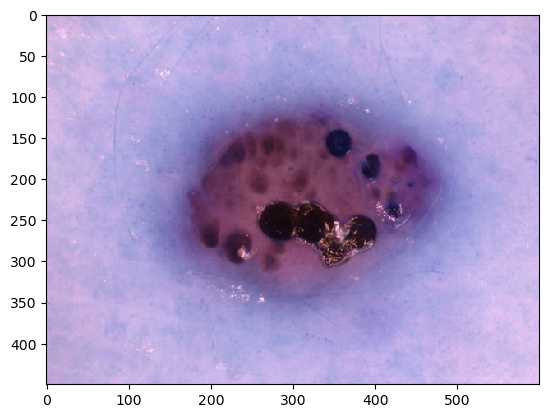

(256, 256, 3)
1/1 [==============================] - 0s 16ms/step
True Label:             image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
142  ISIC_0034471  0.0  0.0  0.0    0.0  0.0  0.0   1.0
Prediction Scores: [[4.2534256e-04 9.9618930e-01 1.0401701e-04 3.7802494e-04 1.9175304e-03
  7.2291068e-04 2.6290456e-04]]
Predicted Label: [1]


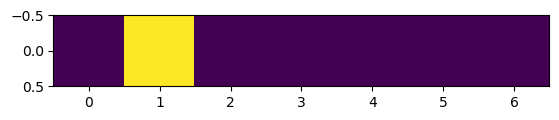

In [16]:
#individual testing

pred_folder = "validation/ISIC2018_Task3_Validation_Input/"
pred_image = "ISIC_0034471"
labels_path = "validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv"
classification = k.models.load_model("final_class.keras", custom_objects={"f_score": f_score, "precision_score": precision_score}) # make sure to run only after training the classification model


pred_label_df = pd.read_csv(labels_path)
pred_label_true = pred_label_df.loc[pred_label_df['image']==pred_image]

test_image = np.array(cv2.imread(os.path.join(pred_folder, pred_image) + ".jpg"))
plt.imshow(test_image, interpolation='nearest')
plt.show()

pred_image = cv2.resize(test_image, (256,256))
print(pred_image.shape)
pred = classification.predict(pred_image[None,])
pred_label = np.argmax(classification.predict(pred_image[None,]), axis=-1)

print(f"True Label: {pred_label_true}")
print(f"Prediction Scores: {pred}")
print(f"Predicted Label: {pred_label}")

plt.imshow(pred, interpolation='nearest')
plt.show() 


(2848, 4288, 3)


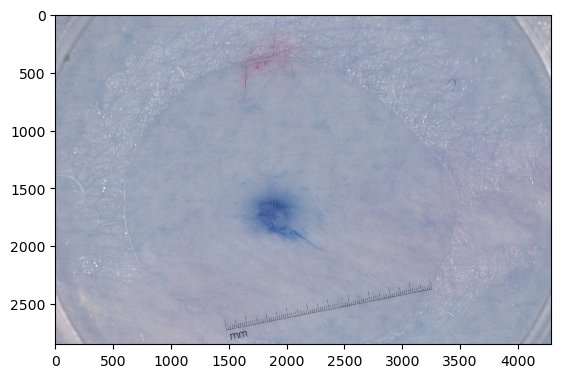

(256, 256, 3)
(1, 256, 256, 3)
1/1 [==============================] - 0s 20ms/step
(1, 256, 256, 1)
(1, 256, 256)


TypeError: Invalid shape (1, 256, 256) for image data

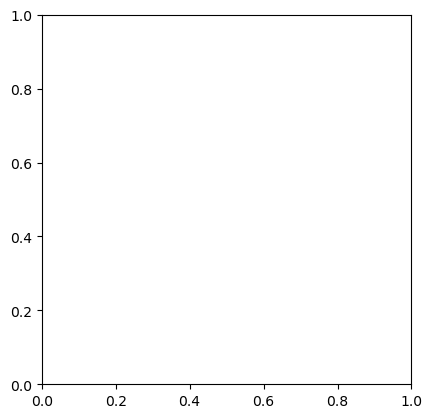

In [27]:
pred_folder = "validation_seg/ISIC2018_Task1-2_Validation_Input"

pred_image = np.array(cv2.imread(os.path.join(pred_folder,"ISIC_0012255.jpg"))) #change to another image if you wish
print(pred_image.shape)

plt.imshow(pred_image, interpolation='nearest')
plt.show()

pred_image = cv2.resize(pred_image, (256,256))
pred_image=pred_image//255
pred_image = pred_image.reshape((1,256,256,3))
pred = model.predict(pred_image)
x = pred[0,:, :, :]
print(x.shape)
plt.imshow(x, interpolation='nearest')
plt.show() 